##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deep Convolutional Generative Adversarial Network - for cats

There are lots of DCGAN cat examples out there, this notebook borrows from a few of them:
 - https://ajolicoeur.wordpress.com/cats/
 - https://github.com/theblackcat102/keras-cat-gan
 
This notebook is derived from the Tensorflow MNIST DCGAN tutorial:
 - https://www.tensorflow.org/beta/tutorials/generative/dcgan

... with the following extensions:
 - custom dataset (Crawford Cats: https://www.kaggle.com/crawford/cat-dataset)
 - generator and discriminator upscaled to higher resolution
 - metrics to track loss
 
TODO:
 - Tensorboard integration
 - multi-gpu support for training

### Import TensorFlow and other libraries

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
# Standard library
from glob import glob
import os
import time

# Packages
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import cv2
from IPython import display

# Modules
import helper

In [4]:
tf.__version__

'2.0.0-rc0'

In [5]:
tf.test.is_gpu_available()

True

In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
# Load the TensorBoard notebook extension - we will open the interface further down, for training
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

# %tensorboard --logdir {logs_base_dir}

### Load and prepare the dataset

In [8]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_CHANNELS = 3

data_dir = 'cat_dataset/cats_bigger_than_64x64' # Data
data_resized_dir = "cat_dataset/resized_data_64x64"# Resized data

results_dir = 'results_' + time.strftime("%Y%m%dT%H%M%S")
os.makedirs(results_dir, exist_ok=True)

In [9]:
# Resize images

if not os.path.exists(data_resized_dir): 
    do_preprocess = True
else:
    do_preprocess = False
    
# do_preprocess = False

if do_preprocess:
    if not os.path.exists(data_resized_dir): os.mkdir(data_resized_dir)

    for each in os.listdir(data_dir):
        image = cv2.imread(os.path.join(data_dir, each))
        image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        cv2.imwrite(os.path.join(data_resized_dir, each), image)


In [10]:
# This part was taken from Udacity Face generator project
def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    :param image_path: Path of image
    :param width: Width of image
    :param height: Height of image
    :param mode: Mode of image
    :return: Image data
    """
    image = Image.open(image_path)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode):
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

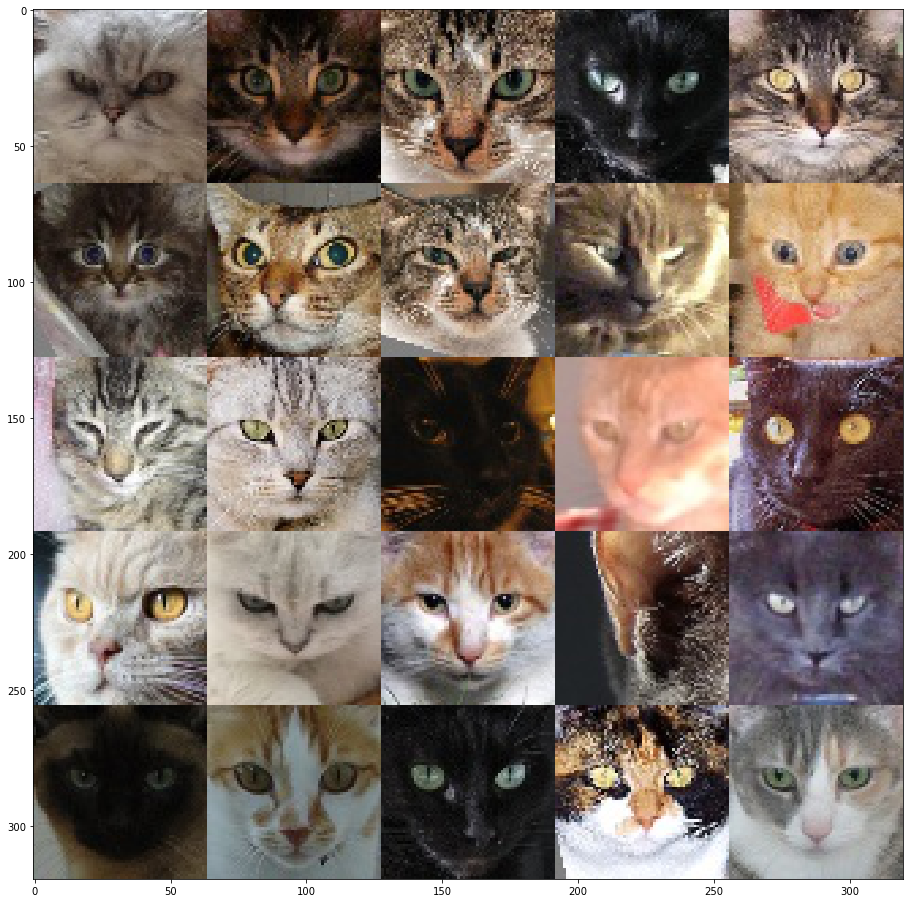

In [11]:
show_n_images = 25
mnist_images = helper.get_batch(glob(os.path.join(data_resized_dir, '*.jpg'))[:show_n_images], IMAGE_WIDTH, IMAGE_HEIGHT, 'RGB')
plt.figure(figsize=(16,16))
plt.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [12]:
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [13]:
train_images = helper.get_batch(glob(os.path.join(data_resized_dir, '*.jpg')), IMAGE_WIDTH, IMAGE_HEIGHT, 'RGB').astype('float32')
assert train_images.shape[1:] == (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
print(train_images.shape)

(9303, 64, 64, 3)


In [14]:
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [15]:
BUFFER_SIZE = 3000
BATCH_SIZE = 256

In [16]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [17]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #
    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512) # Note: None is the batch size
    #
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #
#     model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 64, 64, 64)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    #
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
    #
    return model

Use the (as yet untrained) generator to create an image.

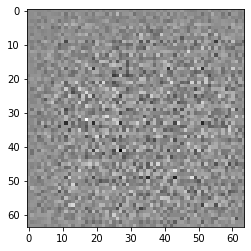

In [18]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [19]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [20]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00014847]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [21]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(0.0002)  # 1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(0.00005)  # 1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop



In [26]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [27]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, g_loss_metric, d_loss_metric):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # Update the metrics
    g_loss_metric.update_state(gen_loss)
    d_loss_metric.update_state(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [28]:
def train(dataset, epochs):
    # Create the metrics
    g_loss_metric = tf.keras.metrics.Mean(name='g_train_loss')
    d_loss_metric = tf.keras.metrics.Mean(name='d_train_loss')

    for epoch in range(epochs):
        start = time.time()
        # Reset the metrics
        g_loss_metric.reset_states()
        d_loss_metric.reset_states()

        for image_batch in dataset:
            train_step(image_batch, g_loss_metric, d_loss_metric)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch,
                             seed)
        
        # Get the metric results
        g_mean_loss = g_loss_metric.result()
        d_mean_loss = d_loss_metric.result()
        g_loss_log.append([g_mean_loss])
        d_loss_log.append([d_mean_loss])
        # mean_accuracy = accuracy_metric.result()        
        
        # Print metrics
        print('Epoch: {}, {:.3f} sec'.format(epoch + 1, time.time()-start))
        print('  losses    (g: {:.3f}) (d: {:.3f}) (g+d: {:.3f})'.format(g_mean_loss, d_mean_loss, g_mean_loss + d_mean_loss))


        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epoch,
                           seed)
    # Plot losses
    #plot_losses(g_loss_log, d_loss_log, epoch=epoch)

**Generate and save images**



In [29]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(12,12))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
#       plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5)  # , cmap='gray')
      this_result = predictions[i, :, :, :] * 127.5 + 127.5
      plt.imshow(this_result.numpy().astype(np.uint8) )  # , cmap='gray')      
      plt.axis('off')

  plt.savefig(os.path.join(results_dir, 'image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [30]:
# Get Tensorboard interface to monitor training
#%tensorboard --logdir {logs_base_dir}

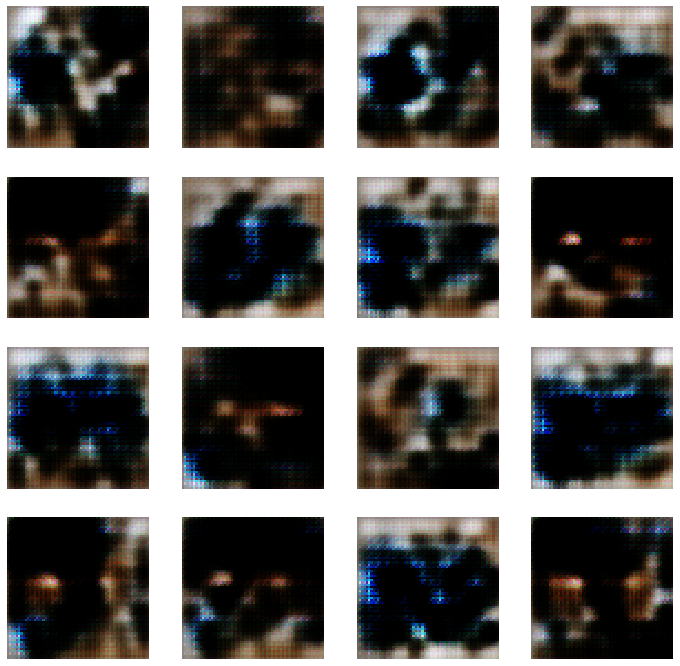

Wall time: 7min 16s


In [31]:
%%time

# Store the training history metrics
g_loss_log = []
d_loss_log = []
    
EPOCHS = 50  # 250
train(train_dataset, EPOCHS)

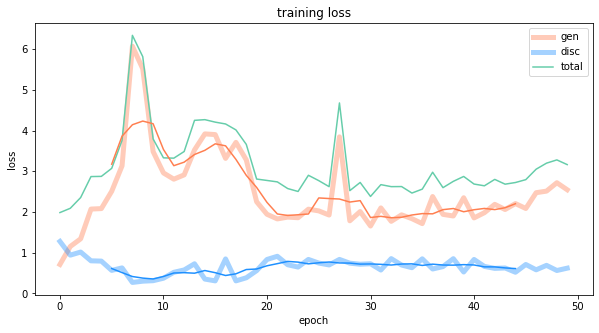

<Figure size 432x288 with 0 Axes>

In [40]:
# Plot training history

"""Plot the training losses."""
total_loss = [g[0].numpy() + d[0].numpy() for g, d in zip(g_loss_log, d_loss_log)]
g_loss = [g[0].numpy() for g in g_loss_log]
d_loss = [d[0].numpy() for d in d_loss_log]
plt.figure(figsize=(10,5))
c1 = 'coral'
c2 = 'dodgerblue'
c3 = 'mediumaquamarine'
plt.plot(g_loss, label='gen', alpha=0.4, linewidth=5, c=c1)
plt.plot(d_loss, label='disc', alpha=0.4, linewidth=5, c=c2)
plt.plot(total_loss, label='total', c=c3)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training loss')

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

xs = [_ for _ in range(len(d_loss))]
if len(xs) > 20:
    # Show smoothed metrics
    window = 5
    plt.plot(xs[window:-window], smooth(g_loss, window)[window:-window], c=c1)
    plt.plot(xs[window:-window], smooth(d_loss, window)[window:-window], c=c2)

plt.show()
plt.savefig(os.path.join(results_dir, 'losses.png'))


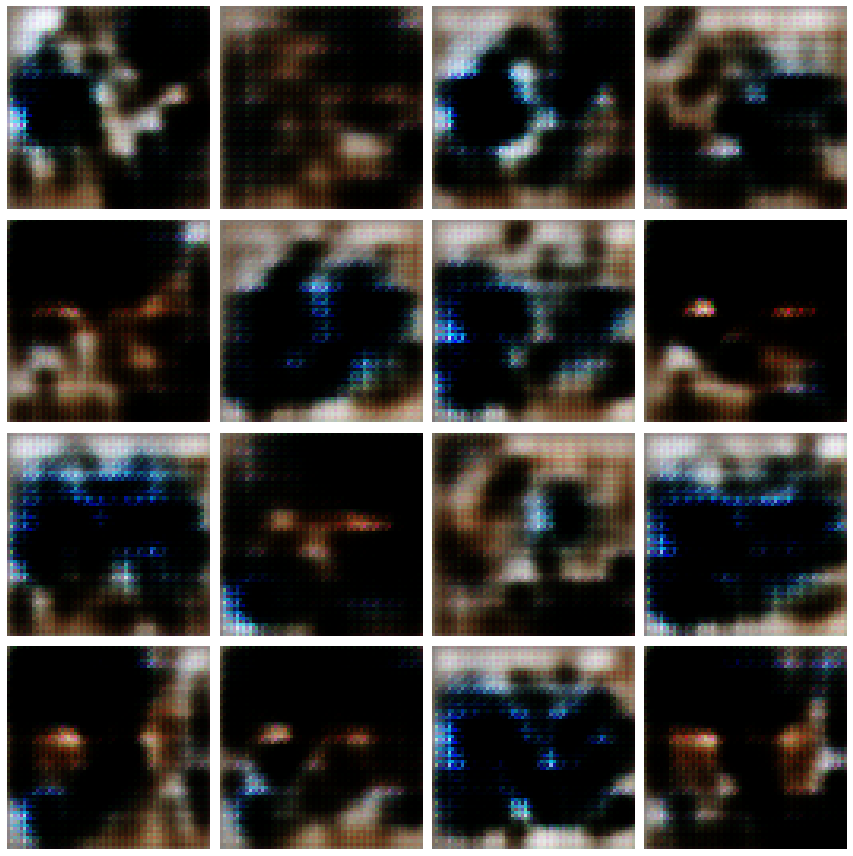

In [41]:
# Test eval
predictions = generator(seed, training=False)

fig = plt.figure(figsize=(12, 12))

for i in range(predictions.shape[0]):
  plt.subplot(4, 4, i+1)
  this_result = predictions[i, :, :, :] * 127.5 + 127.5
  plt.imshow(this_result.numpy().astype(np.uint8) )  # , cmap='gray')
  plt.axis('off')

plt.savefig(os.path.join(results_dir, 'image_at_epoch_{:04d}.png'.format(0)))
plt.tight_layout()
plt.show()


Restore the latest checkpoint.

In [42]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [43]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open(os.path.join(results_dir, 'image_at_epoch_{:04d}.png'.format(epoch_no)))

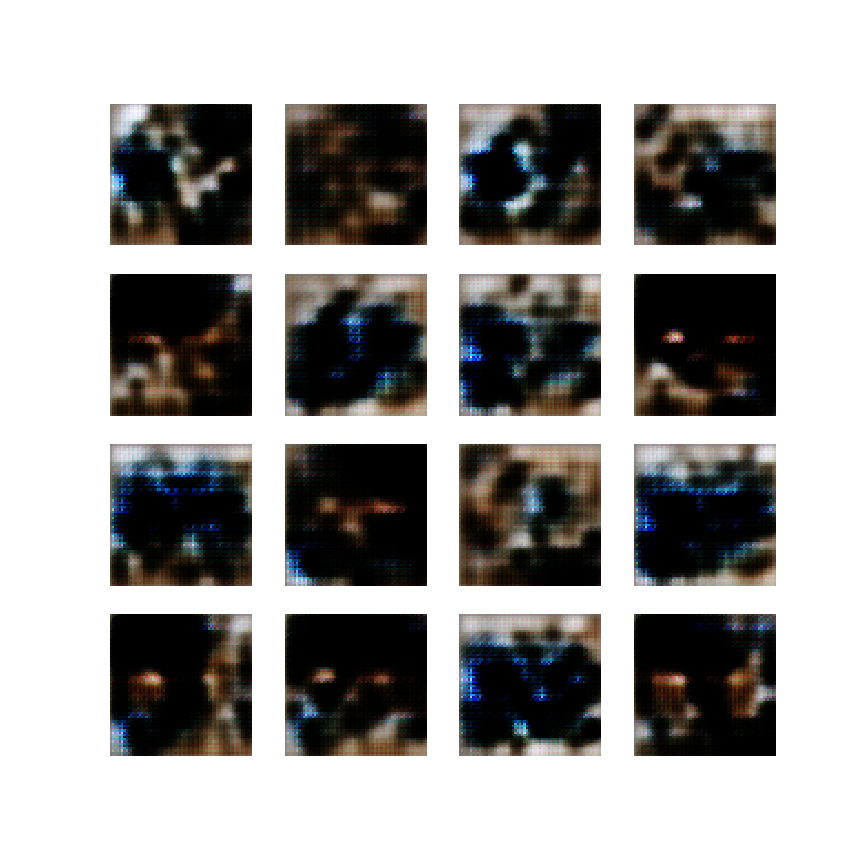

In [45]:
display_image(EPOCHS-1)

Use `imageio` to create an animated gif using the images saved during training.

In [47]:
anim_file = os.path.join(results_dir, 'dcgan-cats.gif')

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob(os.path.join(results_dir, 'image*.png'))
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)